In [1]:
import os
import numpy as np
import jax.numpy as jnp
import jax.random as random
from scipy.stats import gaussian_kde
# from rsnl.metrics import plot_and_save_coverage
from rsnl.examples.contaminated_slcp import calculate_summary_statistics, true_dgp
import matplotlib.pyplot as plt
import pickle as pkl
import arviz as az
import matplotlib.colors as mcolors
import pandas as pd

/Users/ryankelly/python_projects/rsnl/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check x_obs for seed_9
seed = 1
rng_key = random.PRNGKey(seed)
rng_key, sub_key  = random.split(rng_key)
true_params = jnp.array([0.7, -2.9, -1.0, -0.9, 0.6])
# true_params = prior.sample(sub_key1)
x_obs = calculate_summary_statistics(true_dgp(sub_key, *true_params))
x_obs = jnp.around(x_obs, 2)
print(f'x_obs: {x_obs}')

x_obs: [ 1.2000000e-01 -2.7500000e+00  4.7000000e-01 -1.7700000e+00
 -1.6000000e-01 -3.3199999e+00  1.6999999e+00 -2.5999999e+00
  2.3410000e+01 -1.7848999e+02]


In [19]:
with open("../res/contaminated_slcp/rsnl/seed_0/theta.pkl", "rb") as f:
    theta_draws_rsnl = jnp.array(pd.read_pickle(f))

thetas_rsnl = jnp.concatenate(theta_draws_rsnl, axis=0)

with open("../res/contaminated_slcp/snl/seed_0/theta.pkl", "rb") as f:
    theta_draws_snl = jnp.array(pd.read_pickle(f))

thetas_snl = jnp.concatenate(theta_draws_snl, axis=0)

with open("../res/contaminated_slcp/well_specified_snl/seed_0/theta.pkl", "rb") as f:
    theta_draws_well_specified_snl = jnp.array(pd.read_pickle(f))

with open("../res_rnpe/contaminated_slcp/seed_0/thetas.pkl", "rb") as f:
    try:
        # data = pkl.load(f)
        theta_draws_rnpe = pkl.load(f)['posterior_samples']['RNPE']
    except ModuleNotFoundError:
        theta_draws_rnpe = jnp.array(pd.read_pickle(f))

theta_well_specified_snl = jnp.concatenate(theta_draws_well_specified_snl, axis=0)

In [21]:
rsnl_theta_plot = {}
snl_theta_plot = {}
snl_well_specified_theta_plot = {}
rnpe_theta_plot = {}

for i in range(5):
    rsnl_theta_plot['theta' + str(i+1)] = thetas_rsnl[:, i]
    snl_theta_plot['theta' + str(i+1)] = thetas_snl[:, i]
    snl_well_specified_theta_plot['theta' + str(i+1)] = theta_well_specified_snl[:, i]
    rnpe_theta_plot['theta' + str(i+1)] = theta_draws_rnpe[:, i]

var_name_map = {}
reference_values = {}
for ii, k in enumerate(rsnl_theta_plot):
    var_name_map[k] = fr'$\{k[:-1]}_{k[-1]}$'
    reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

In [22]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 25})
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['axes.labelsize'] = 25
plt.rcParams["axes.unicode_minus"] = False

jj
jj
jj
jj
jj
jj
jj
jj
jj
jj


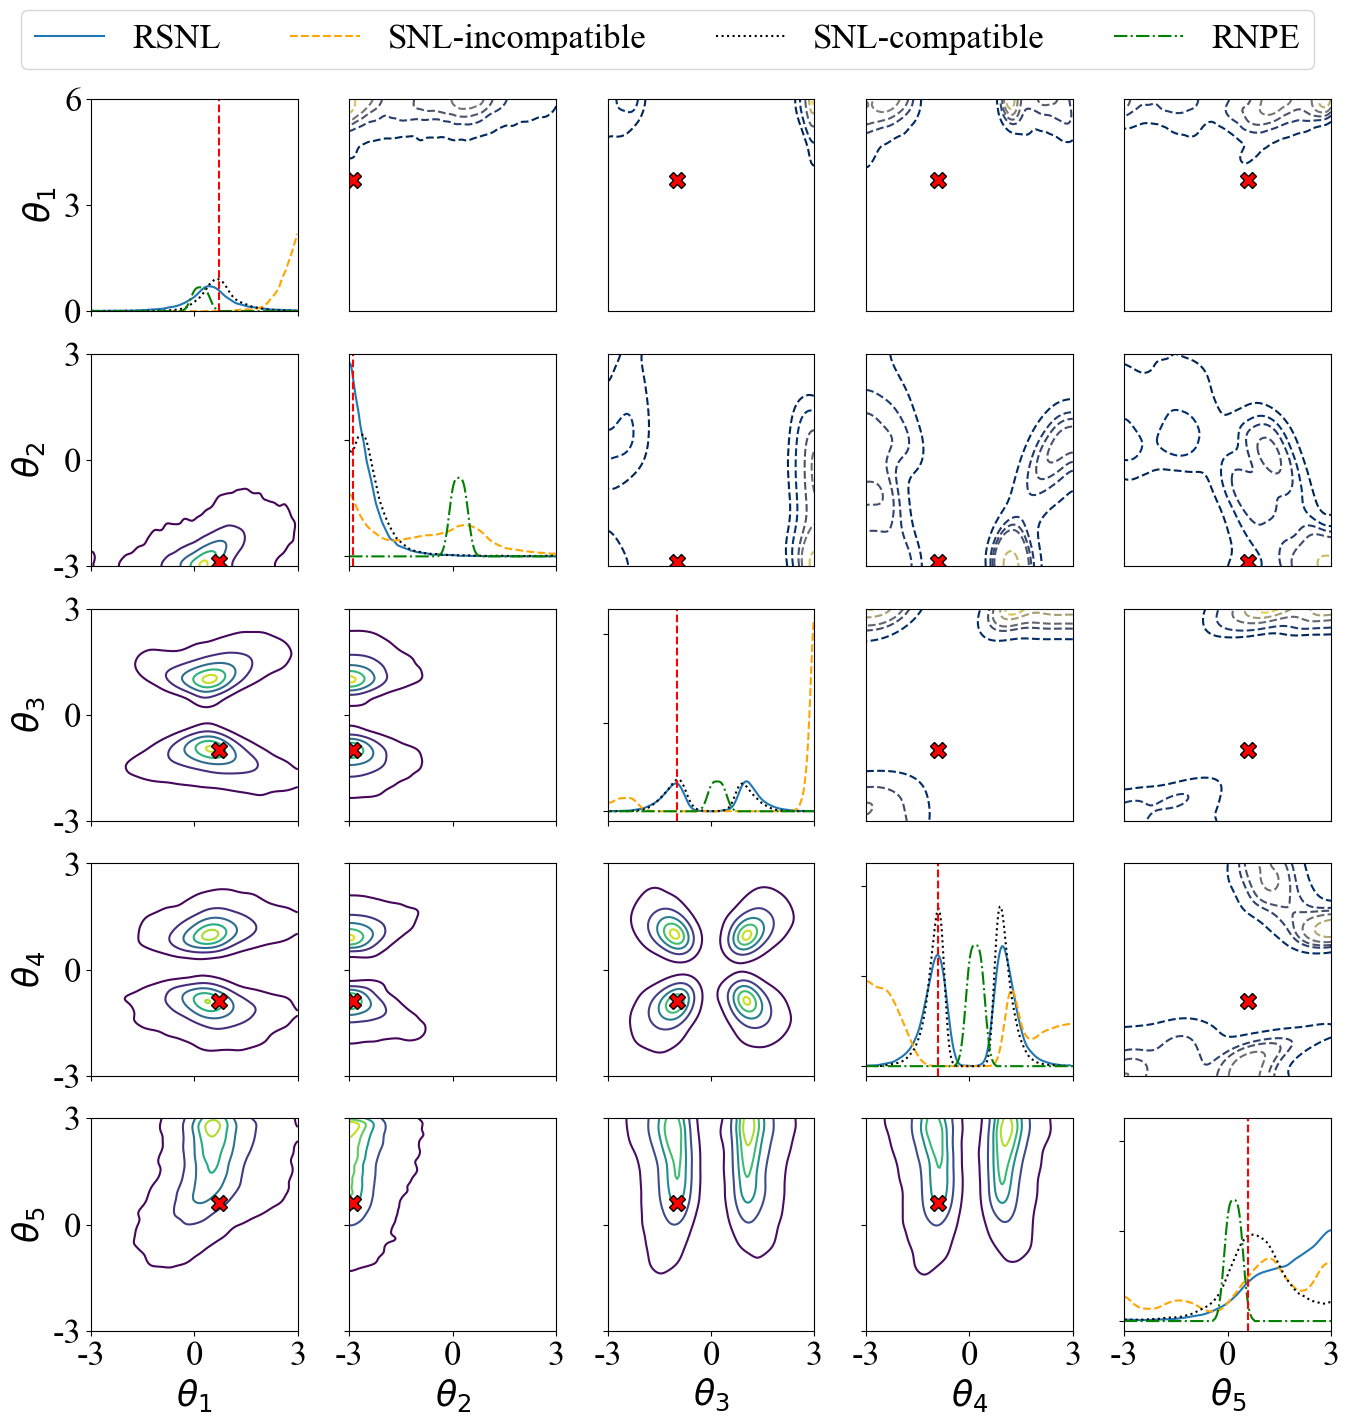

In [30]:
fig, axes = plt.subplots(5, 5, sharey=False, figsize=(16, 16))

old_axes = np.empty((5, 5), dtype='object')

for i in range(5):
    for j in range(5):
        old_axes[i][j] = axes[i][j].axes
axes = az.plot_pair(rsnl_theta_plot,
                    kind='kde',
                    reference_values=reference_values,
                    reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
                    kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95],
                                'contour_kwargs': {"colors":None, "cmap":plt.cm.viridis},
                                'contourf_kwargs': {"alpha":0}},
                    ax=axes,
                    labeller=az.labels.MapLabeller(var_name_map=var_name_map,),
                    # textsize=18,
                    marginals=True,
                    marginal_kwargs={'label': 'RSNL'},
                    # show=False
                    # figsize=(64, 64)
                    )

curr_fig = plt.gcf()
for ii, ax_ii in enumerate(axes):
    for jj, ax_jj in enumerate(ax_ii):
        if ii == jj:  # only marginal for now
            # az.plot_density(snl_misspec_theta_plot['theta' + str(ii+1)], ax=ax_jj, colors='orange', point_estimate=None)
            # az.plot_density(snl_correct_theta_plot['theta' + str(ii+1)], ax=ax_jj, colors='black', point_estimate=None)
            # xs = np.arange(-3, 3, 100)
            # kde_jj = kde(snl_correct_theta_plot['theta' + str(ii+1)])
            # ax_jj.plot(xs, kde_jj(xs), color='black')
            az.plot_dist(snl_theta_plot['theta' + str(ii+1)],ax=ax_jj, color='orange', plot_kwargs={'linestyle': 'dashed'}, label='SNL-incompatible')
            az.plot_dist(snl_well_specified_theta_plot['theta' + str(ii+1)],ax=ax_jj, color='black', plot_kwargs={'linestyle': 'dotted'}, label='SNL-compatible')
            az.plot_dist(rnpe_theta_plot['theta' + str(ii+1)],ax=ax_jj, color='green', plot_kwargs={'linestyle': 'dashdot'}, label='RNPE')
            if ii != 0:
                ax_jj.get_legend().remove()
            else:
                ax_jj.legend(bbox_to_anchor=(6, 1.5), ncol=4,
                            #  mode="expand", borderaxespad=0.
                             )
            ax_jj.axvline(x=true_params[jj], color='red', linestyle='dashed')
        if ii < jj:
            print('jj')
            # fig.add_subplot()
            ax_jj._remove_method = None
            ax_jj.figure = curr_fig
            ax_jj.set_xlim(-3, 3)
            ax_jj.set_ylim(-3, 3)
            # print("Axis type: ", type(ax_jj))
            ax_jj.set_visible(True)
            # ax_jj.axis('on')
            ax_jj = az.plot_kde(snl_theta_plot['theta' + str(jj+1)],
                                snl_theta_plot['theta' + str(ii+1)],
                                ax=ax_jj,
                                hdi_probs=[0.05, 0.25, 0.5, 0.75, 0.95],
                                contour_kwargs={"colors": None, "cmap":plt.cm.cividis, 'linestyles': 'dashed'},
                                contourf_kwargs={"alpha":0}, show=False)
            ax_jj.plot(true_params[jj], true_params[ii], color='red', marker= 'X', markersize=12, markeredgecolor='k')
            ax_jj.axes = old_axes[ii, jj]
            ax_jj.axes.get_xaxis().set_visible(False)
            ax_jj.axes.get_yaxis().set_visible(False)
            # ax_jj.set_visible(False)
            fig.add_subplot(ax_jj)
            # plt.add_axes(ax)
            # axes[ii, jj] = ax
        #     axes[ii, jj] = axes2[jj, ii]
            # ax_jj.plot(x=0, y=0)
# plt.axes().get_xaxis().set_visible(True)
# plt.axes().get_yaxis().set_visible(True)
for i in range(5):
    for j in range(5):
        if i != j:
            axes[i][j].set_ylim(-3, 3)
            axes[i][j].set_yticks([-3, 0, 3])
        else:
            if i == 0:
                axes[i][j].set_yticks([0, 3, 6])
                axes[i][j].set_ylim(0, 6)
        axes[i][j].set_xlim(-3, 3)
        axes[i][j].set_xticks([-3, 0, 3])

# plt.show()
plt.subplots_adjust(wspace=0.25)  # adjust the space between the subplots
plt.savefig("slcp_joint_all.pdf", bbox_inches='tight')

In [7]:
with open("../res/contaminated_slcp/rsnl/seed_1/adj_params.pkl", "rb") as f:
    adj_params = jnp.array(pkl.load(f))

adj_params = jnp.concatenate(adj_params, axis=0)


ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [ ]:
# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams.update({'font.size': 35})

## Adjustment Plots

In [ ]:
rng_key = random.PRNGKey(0)
prior_samples = random.laplace(rng_key, shape=(10000, 2))

for i in range(10):
    az.plot_dist(adj_params[:, i],
                 label='Posterior',
                 color='black')
    az.plot_dist(prior_samples[:, i],
                 color=mcolors.CSS4_COLORS['limegreen'],
                 plot_kwargs={'linestyle': 'dashed'},
                 label='Prior')
    plt.xlabel("$\gamma_{%s}$" % (i+1), fontsize=35)
    plt.ylabel("Density", fontsize=35)
    plt.xlim([-10, 10])
    plt.ylim(bottom=0)
    plt.xticks([-10, -5, 0, 5, 10], fontsize=35)
    plt.yticks(fontsize=35)
    plt.legend(fontsize=35,
               loc='upper left',
               borderpad=0.1, labelspacing=0.1, handletextpad=0.1)

    plt.tight_layout()
    plt.savefig(f'contaminated_slcp_adj_param_{i+1}.pdf', bbox_inches='tight')
    plt.clf()